<a href="https://colab.research.google.com/github/longhowlam/python_hobby_stuff/blob/master/GTST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goede Tijden Slechte Tijden 

Text analysis of Dutch Soap series GTST summaries


---



![cast](https://assets.televizier.nl/upload/g/t/Goede-Tijden--Slechte-Tijden-20175.jpg)

## Set up 

Summaries from 1991 until 2012 are on my Google Drive, I need to mount it first

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


install spacy nl and pyldavis 

In [2]:
!python -m spacy download nl
!pip install pyldavis

     |████████████████████████████████| 15.1 MB 8.6 MB/s 
  Created wheel for nl-core-news-sm: filename=nl_core_news_sm-2.3.0-py3-none-any.whl size=15073758 sha256=69f9f91834bb0cc39d8e65ded07ccdd47c61312bce898da5f24a46f5fd961979
  Stored in directory: /private/var/folders/y6/jrqktfnx2dxdcryrpygdr2s9rt72yb/T/pip-ephem-wheel-cache-_5d9fgqa/wheels/12/3b/3c/9da5b39ba88c3a107db655ea6c60237b547f3138917c918321
Successfully built nl-core-news-sm
  Attempting uninstall: nl-core-news-sm
    Found existing installation: nl-core-news-sm 2.1.0
    Uninstalling nl-core-news-sm-2.1.0:
      Successfully uninstalled nl-core-news-sm-2.1.0
You should consider upgrading via the '/Users/lamlon/anaconda3/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('nl_core_news_sm')
✔ Linking successful
/Users/lamlon/anaconda3/lib/python3.7/site-packages/nl_core_news_sm -->
/Users/lamlon/anaconda3/lib/python3.7/site-packages/spacy/data/n

In [3]:
import pandas as pd
import seaborn as sns

import spacy
nlp = spacy.load("nl")

# Gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim

/Users/lamlon/.vscode/extensions/ms-python.python-2020.7.96456/pythonFiles/lib/python/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


In [11]:
nlp

## Import GTST summaries

In [5]:
#gtst = pd.read_csv("/content/drive/My Drive/DataSets/GTST_Daily_data.csv")
gtst = pd.read_csv("GTST_Daily_data.csv")
gtst.sample(5)

,text_of_1month,datums,datums2
3577,Sjors is verbijsterd door een koppelpoging va...,Dinsdag 16 februari 2010,16 2 2010
1293,Roos ontkent bij hoog en laag dat ze weer bou...,Woensdag 7 mei 1997,7 5 1997
2805,Dennis wil verder in zijn relatie met Charlie...,Donderdag 3 november 2005,3 11 2005
1290,"Roos vertrouwt de zaak niet, wanneer blijkt d...",Vrijdag 2 mei 1997,2 5 1997
3837,Lorena wijst Charlie op de keerzijde van haar...,Maandag 18 april 2011,18 4 2011


In [47]:
gtst.shape

(4090, 5)

In [6]:
gtst = gtst.assign(
    datums2 = gtst.datums2.str.lstrip(),
    datum = lambda x: pd.to_datetime(x['datums2'], format='%d %m %Y', errors = "coerce")
)

In [14]:
gtst.text_of_1month[2]

' Linda wil hogerop in het modellenvak. De ruzie tussen Peter en Willem Kelder loopt uit op een gevecht. Helen maakt zich zorgen over haar vroegere leerling Peter, die bij Arnie intrekt. '

In [20]:
doc = nlp(gtst.text_of_1month[2])
doc.ents[1].label_

'PERSON'

## NLP Stuff

### Count the number of PERSONS found in a text
Use SpaCy to find entiies, and in our case PERSONS (PER)

In [21]:
def count_persons(text):
  doc = nlp(text)
  return list(map(lambda x: x.label_, doc.ents)).count('PERSON') # PERSON instead of PER in later versions of spacy

In [22]:
count_persons(gtst.text_of_1month[2])

3

In [23]:
%%time
gtst = (
    gtst
    .assign(
        n_persons = gtst.text_of_1month.apply(count_persons)
    )
) 

CPU times: user 43.7 s, sys: 671 ms, total: 44.4 s
Wall time: 44.8 s


### Number of PERSONS mentioned in summaries over time

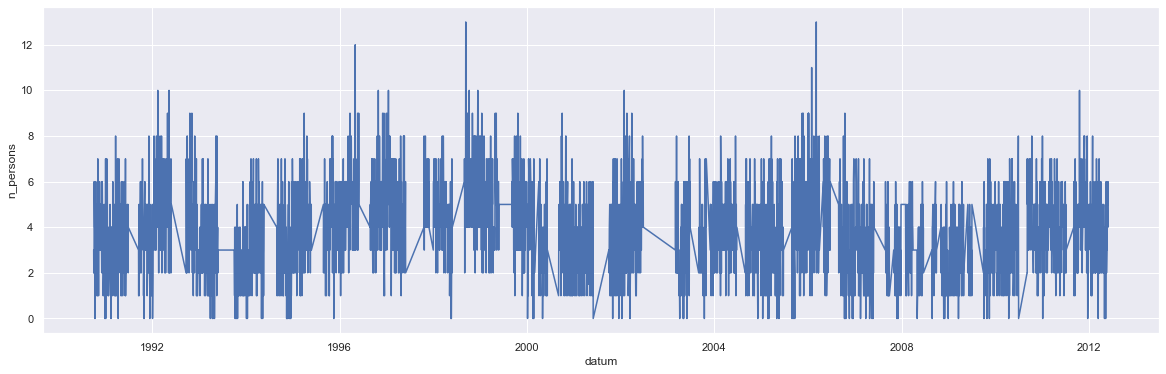

In [24]:
sns.set(rc={'figure.figsize':(20,6)})
sns.lineplot(x="datum", y = "n_persons", data = gtst)

### Alternative plot

In [0]:
!pip install calmap

In [0]:
events = pd.Series(gtst.n_persons.ravel(), index = gtst.datum.ravel())

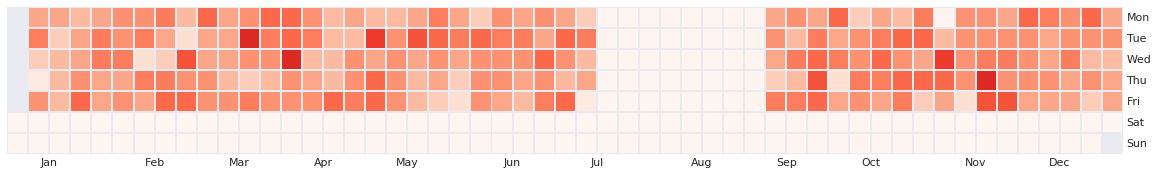

In [0]:
import calmap
calmap.yearplot(events, year=2011)


## Topic Modeling


### Clean the texts

In [25]:
def clean_review(x):
    doc = nlp(x)
    tokens = [token.text for token in doc if (not token.is_punct) & (not token.is_stop)]
    return " ".join(tokens)
  
review_sample = (
    gtst
    .assign(
        cleaned_review = gtst.text_of_1month.apply(clean_review)
    )
)  

### Tokenize

In [26]:
%%time 

from pprint import pprint
from collections import defaultdict

# remove common words and tokenize
nlstop = spacy.lang.nl.stop_words.STOP_WORDS
texts = [
    [word for word in document.lower().split() if word not in nlstop]
    for document in review_sample.cleaned_review
]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

### Create dictionary and corpus

In [27]:
dictionary = corpora.Dictionary(texts)
print(dictionary)
corpus = [dictionary.doc2bow(text) for text in texts]

Dictionary(5156 unique tokens: ['alberts', 'arnie', 'doktersadvies', 'helen', 'helmink']...)


### create topic model

In [28]:
%%time
review_lda = LdaModel(corpus, num_topics = 16, id2word = dictionary, passes = 10)

CPU times: user 13.7 s, sys: 109 ms, total: 13.8 s
Wall time: 13.9 s


In [29]:
review_lda_topics = review_lda.print_topics(num_topics=16 )
review_lda_topics

[(0,
  '0.021*"robert" + 0.017*"laura" + 0.017*"kim" + 0.016*"dian" + 0.015*"jef" + 0.015*"anita" + 0.012*"probeert" + 0.012*"julian" + 0.012*"bowien" + 0.012*"roos"'),
 (1,
  '0.056*"affaire" + 0.050*"lucas" + 0.037*"slaat" + 0.029*"bekentenis" + 0.023*"stalker" + 0.022*"voelt" + 0.022*"werk" + 0.021*"stort" + 0.021*"huis" + 0.020*"gebeurd"'),
 (2,
  '0.025*"jef" + 0.023*"elkaar" + 0.022*"weet" + 0.019*"begrijpt" + 0.015*"lint" + 0.014*"nacht" + 0.014*"brengen" + 0.014*"familie" + 0.013*"wijze" + 0.013*"voelt"'),
 (3,
  '0.032*"raakt" + 0.030*"ontdekt" + 0.027*"jef" + 0.021*"winnen" + 0.019*"teleurgesteld" + 0.014*"belofte" + 0.014*"houden" + 0.014*"moeilijke" + 0.013*"prijs" + 0.013*"moeder"'),
 (4,
  '0.093*"mike" + 0.055*"nina" + 0.031*"krijgt" + 0.025*"noud" + 0.022*"weet" + 0.020*"stalker" + 0.020*"janine" + 0.018*"terug" + 0.016*"huwelijk" + 0.014*"begint"'),
 (5,
  '0.046*"krijgt" + 0.028*"valerie" + 0.026*"ludo" + 0.021*"horen" + 0.020*"janine" + 0.020*"conflict" + 0.019*"verl

In [31]:
%%time 

vis_data = pyLDAvis.gensim.prepare(review_lda, corpus, dictionary)
pyLDAvis.display(vis_data)

CPU times: user 4.57 s, sys: 159 ms, total: 4.73 s
Wall time: 8.53 s


## LSA model

In [35]:
from gensim.models import LsiModel

In [33]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in texts]

In [36]:
lsamodel = LsiModel(doc_term_matrix, num_topics = 10, id2word = dictionary)  # train model
    

In [40]:
## info on latent factors (topics)
print(lsamodel.print_topics(num_topics = 10, num_words = 15))

[(0, '0.383*"ludo" + 0.295*"janine" + 0.254*"jef" + 0.218*"robert" + 0.218*"laura" + 0.214*"charlie" + 0.171*"probeert" + 0.161*"barbara" + 0.150*"rik" + 0.141*"krijgt" + 0.140*"gaat" + 0.136*"anita" + 0.135*"nina" + 0.134*"dian" + 0.130*"sjors"'), (1, '-0.347*"ludo" + -0.254*"charlie" + 0.233*"arnie" + -0.224*"sjors" + 0.223*"jef" + 0.221*"roos" + 0.211*"suzanne" + -0.204*"nina" + 0.187*"daniël" + 0.182*"robert" + 0.179*"linda" + 0.174*"laura" + 0.170*"helen" + 0.166*"dian" + -0.147*"nick"'), (2, '0.552*"ludo" + 0.422*"janine" + -0.381*"charlie" + -0.234*"sjors" + -0.198*"barbara" + -0.190*"laura" + -0.169*"robert" + -0.162*"jef" + -0.144*"bing" + -0.137*"dennis" + -0.117*"jack" + -0.101*"nick" + -0.085*"rik" + 0.083*"daniël" + -0.081*"noud"'), (3, '0.347*"robert" + 0.261*"barbara" + -0.258*"sjors" + 0.252*"jef" + 0.240*"ludo" + -0.211*"nina" + -0.208*"bing" + 0.200*"stefano" + -0.191*"jack" + 0.187*"laura" + -0.153*"lorena" + -0.149*"janine" + -0.141*"maxime" + -0.139*"daniël" + -0.1

The V matrix

In [43]:
from gensim.matutils import corpus2dense

In [44]:
V = corpus2dense(lsamodel[doc_term_matrix], len(lsamodel.projection.s)).T / lsamodel.projection.s

In [45]:
V

array([[ 3.48567845e-03,  1.25887924e-02,  1.05412248e-03, ...,
         6.21148371e-03,  1.01746138e-02,  1.02112266e-03],
       [ 6.91606126e-03,  8.70147180e-03, -6.33186937e-03, ...,
         4.23310372e-03,  1.21476051e-02,  4.79448437e-05],
       [ 5.41661123e-03,  1.93317301e-02,  8.46107306e-04, ...,
         1.05579055e-02,  1.69917175e-02,  3.95821893e-03],
       ...,
       [ 1.93785097e-02, -7.12087676e-03,  6.43810063e-03, ...,
        -2.04568316e-03,  3.15581014e-02, -3.79539716e-03],
       [ 1.12386248e-02, -6.41772434e-03, -1.92836185e-02, ...,
        -9.14569591e-03,  9.50261236e-03,  6.75098886e-03],
       [ 1.43547702e-02, -1.63304697e-02,  1.80744399e-02, ...,
        -5.10447027e-02, -5.19897478e-03, -6.66195432e-03]])

In [46]:
V.shape

(4090, 10)